# Refining Models
### This notebook will be used to explain the algorithms used in the Solicitation Review Tool, including explanation of the model parameters and documentation about optimization efforts

#### Load Data
First, we will load the data. For the purpose of this explanation, we will be using a binary classifier, but you can as easily get the three-way classifier by leaving out the convert_to_binary step in cell one and setting dataDict=raw

In [1]:
from sklearn.externals import joblib
import dataHandling
import matplotlib.pyplot as plt

raw = joblib.load('binaries/dataDump_20161122.pkl')
dataDict = dataHandling.convert_to_binary(raw)


Now that we have our data, let's have a look at it

In [2]:
dataDict.keys()

dict_keys(['description', 'target_names', 'DESCR', 'data', 'target'])

The dataDict object is a dictionary. 'description' is a simple description of the dataset. 'target' is a list of integer values (in this case, 1 or 0) representing the grade assigned to each solicitation by its index. 'data' contains the tokenized, lemmatized text, which we will vectorize in the next step. the only other key to worry about is 'target_names', which contains only two values: RED and GREEN, which correspond to 0 and 1; these are the qualitative labels for the values in 'target' (since we need to pass in a vector of numbers for classification).

#### Prepare the data for classification
For this section, we will essentially be doing three things: vectorizing the data (turning the text data into a vector of numbers that can be used by the classifiers later). There are many ways to vectorize data, but we are using what's called a TF-IDF Vectorizer. 

When vectorizing text, one essentially wants to end up with a distribution showing the prevalence of different words within a given document. Using the more basic count vectorizer will yield a sparse matrix with a count of the number of times a given word occurred in a document. This, however, is not the best approach in all cases; for instance, when one is dealing with documents of varying lengths, using a simple count vectorizer could lead to problems where certain words might appear very often in a longer document, however the higher number of occurrences might not be an indication of how the document should be classified. The TF-IDF vectorizer accounts for document length, though; TF-IDF stands for 'Term Frequency Inverse Document Frequency', referring to the normalization step that was added to the count vectorizer. 

Scikit-Learn has a built-in TF-IDF vectorizer function built into its feature_extraction library. We will now import the TF-IDF vectorizer module and instantiate the vectorizer. A note on the parameters: 
* ```sublinear_tf``` is referring to sublinear term frequency, a parameter that uses a logarithm of term frequency instead of a count, since several occurrences of a word is not necessarily significant for our problem. 
* ```max_df``` refers to the maximum document frequency; in other words, if a word appears in more than a given percentage of documents, it will be ignored, as it's unlikely to be a significant predictor of anything. I've set the parameter to .5, so any words that appear in more than 50% of documents will be ignored during classification. 
* Although I've taken steps already to remove stopwords from the tokenized text, I'm also setting the ```stop_words``` parameter here to English, which will tell Scikit Learn to ignore any of the traditional English stopwords (a, an, the, it, what, etc). 

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')

Now that we have the vectorizer in place, let's separate the data into train/test pieces. I built a function in dataHandling that will divide the dataset into two pieces. The second parameter of the function is the size of the test set; I've set it to .2 here, or 20% of the dataset, but that's not a hard and fast rule by any means.

Once you have the train/test sets, we will need to isolate the targets from the data; targets will be ```y```, while data will be ```X```, as it is with most mathematical functions in machine learning (we'll get to the math a bit later). Finally, we'll use the vectorizer on the data. Note that we're running ```fit_transform``` on the training data, but only ```transform``` on the test data; the vectorizer used for the training dataset will be the foundational vectorizer, and we need further vectorized texts to yield sparse matrices with the same shape as the matrix returned by vectorizing the training data; therefore ```X_test``` is being formed using the same vectorizer that was created with ```X_train```.

We'll also pull out categories and feature names, which will be used later on for things like printing the most informative features in certain models.

In [4]:
data_train, data_test = dataHandling.make_train_test(dataDict, .2)
y_train, y_test = data_train['target'], data_test['target']
X_train = vectorizer.fit_transform(data_train['data'])
X_test = vectorizer.transform(data_test['data'])

categories = dataDict['target_names']
feature_names = vectorizer.get_feature_names()
feature_names = np.asarray(feature_names)

### Ridge Classifier
Now that we've prepared our data, it's time to start in on the classifiers. 

In writing this, I'm assuming the reader has at least some familiarity with basic regression analysis techniquest like Ordinary Least Squares regression; I'll therefore leave out explaining these concepts in detail and will instead focus on the algorithms I've found useful for this problem set. The first one we'll be trying out is the ```ridge``` classifier. 

Going back to OLS, you can think of our classification problem as a classic OLS regression problem. Let's refresh on the equation for an OLS regression model: 
$$ Y = \beta_1X_1 + \beta_2X_2 + \epsilon $$
Y is the dependent variable, the thing we're trying to predict; in this case, it is whether a document should be classified as 'green' or 'red'. In our data, it is 'target', and it is a number between 0 and 1; the closer the number is to 1, the higher the probability that the document is going to be labeled 'GREEN'. Think of each X then being a word, and each $ \beta\ $ being the coefficient assigned to that word by the algorithm. Some words, in our case words like 508, accessibility, and GPAT, would probably have very high coefficients; if those words show up, the predicted score will increase by the amount of the coefficient. 

Essentially, what we're aiming for with OLS regression is $ \hat{\beta} $, the estimated coefficient that represents the closest measure of the theoretical $ \beta $ (for the population). When you have a dataset with a high degree of multicollinearity, or when your dataset has many possible parameters, OLS will not be the tool to reach for, as the model will be highly prone to over-fitting (in short, the model's coefficients are very good at predicting values within the sample, but very bad at predicting new values introduced from outside the sample, referred to as the level of prediction error (PE)). What it essentially comes down to is that the coefficients will have a wide variance, but thanks to the [variance-bias tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html), we can introduce some parameter constraints; these constraints will reduce variance, making the coefficients more accurate at predicting out-of-sample data. This constraint is known as a penalty. Now let's try ridge regression and OLS regression on our train/test sets to measure their respective accuracies. 

First, though, a function for testing a classifier:

In [5]:
from sklearn import metrics
def trim(s):
    return s if len(s) <= 80 else s[:77] + "..."

def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    try:
        score = metrics.accuracy_score(y_test, pred)
    except:
        score = metrics.r2_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    return score

In [7]:
from sklearn.linear_model import LinearRegression

OLS = LinearRegression()
OLS.fit(X_train, y_train)
OLS_pred = OLS.predict(X_test)
metrics.r2_score(y_test, OLS_pred)

0.44929695397987324

Now, it's important to note here that OLS regression can't give us an accuracy score, per se, as it's not a classifier (classifiers return a 0-1 score for each category, while regressions output a number). I'm instead using the R-Squared value (AKA the coefficient of determination), an approximate measure of how well future samples are likely to be predicted by the model. At .45, it is pretty low (note that this number may differ slightly from what you see, as the train/test operation uses a random shuffle, so the dataset you're working with will be different from mine and the R-Squared will likely vary by +/-.3); essentially, this is saying that the model can account for about 43% of the variation in the sample, which gives us an idea of how well it will do in predicting new values from out of the sample.

With an OLS example as our baseline, let's try a ridge regression, which will add constraints on the parameters, introducing bias, but reducing variance. A note on the parameters: I've adjusted two of the ridge parameters away from their defaults for the purpose of improving accuracy. $ \alpha $ represents the regularization strength (i.e. the size of the penalty applied). The following code snippet is an attempt to find an optimal value for alpha:

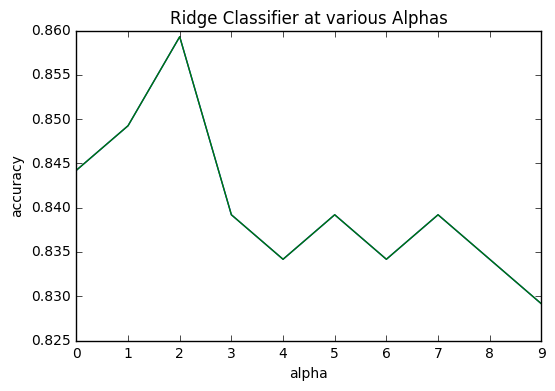

In [28]:
from sklearn.linear_model import RidgeClassifier
result = []
alpha = []
for i in range(0, 10):
    ridge = RidgeClassifier(alpha=i, solver="sag")
    ridge.fit(X_train, y_train)
    ridge_pred = ridge.predict(X_test)
    metrics.accuracy_score(y_test, ridge_pred)
    alpha.append(i)
    result.append(metrics.accuracy_score(y_test, ridge_pred))

plt.plot(alpha, result)
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('Ridge Classifier at various Alphas')
plt.show()

As we can see, the peak accuracy of $ \alpha $ is at $ \alpha $ = 2. This is the value we'll feed it for classification. The second parameter is the solver; SKLearn allows for about 6 different solvers, and I went with SAG (Stochastic Average Gradient descent); after testing others, SAG offers the highest measured accuracy levels, and it is generally the go-to solver when dealing with a large number of features. We'll get into Stochastic Gradient Descent soon. 

In [29]:
ridge = RidgeClassifier(alpha=2, solver="sag")
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
metrics.accuracy_score(y_test, ridge_pred)

0.85929648241206025

At nearly 86% accuracy, it would be safe to say that the Ridge model is a strong improvement over the OLS model. Let's now move into another linear model, Logistic Regression.